In [6]:
## Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplot2tikz

In [7]:
## Pay-to-exit research questions
## RQ1 For an adversary with \alpha stake, how much does it need to pay to
## exiting validators to achieve \alpha'\leq0.33 stake in the system? In this scenario the adversary would
## reimburse all expected rewards to the validator for the next 1-2-3 (TBD) years (discounted at present value).
## RQ2 The same as in RQ1 but the adversary only reimburses the opportunity cost, i.e.,
## say the difference between validator rewards - Uniswap LP rewards (assuming Uniswap LP is the 2nd best option for validators).

## Pay-to-fork research questions
## RQ1 how much the adversary needs to pay for buying X attestations?
## RQ2 Same as RQ1 but the adversary also needs to cover attestation equivocation penalties for these X bought attestations.

## Relevant Pectra-EIPs for this work
## EIP-7002
## EIP-7549 Move the committee index out of the signature: more efficient attestation/signature aggregation

In [8]:
## Best resource on the protocol: https://eth2book.info/latest/book.pdf

In [9]:
## Some constants that we deem given (maybe periodically update)
stakedETHamount = (
    34385053  # (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking
)

noOfValidators = (
    1074533  # (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking
)

noEpochsPerYear = 82181.25
maxIssuancePerYear = 940.8659 * math.sqrt(
    noOfValidators
)  ## the constant is coming from epochs per year (roughly)
APR = 2940.21 / math.sqrt(noOfValidators)
proposerReward = 0
attestationReward = 0
W_s = 14  # weights page 100
W_t = 26
W_h = 14
W_y = 3  # sync reward weight
W_p = 12.5  # proposer weight
W_Sigma = 64  # defined at page 109
T = stakedETHamount  # defined at page 102
n = 32  # number of increments (the validator's balance is assumed to be 32 ETH uniformly (for the sake of simplicity))
base_reward_factor = 64  # https://ethereum.stackexchange.com/questions/153722/base-reward-formula-enquiry
b = (1000000000 * base_reward_factor) / math.sqrt(
    32000000000 * noOfValidators
)  # base reward per increment

# Attestation penalties page 109 in eth2book
attestation_missing_penalty = 0.625 * T * b  # page 107
wrong_source_attestation = (-W_s - W_t) / W_Sigma
MIN_SLASHING_PENALTY_QUOTIENT_BELLATRIX = 1 / 32  # defined at page 116
# correlation penalty page 117
# other penalties

attestation_reward_per_validator = (b / 64) * 57 / 1e9  # in ETH

# Pay To attest


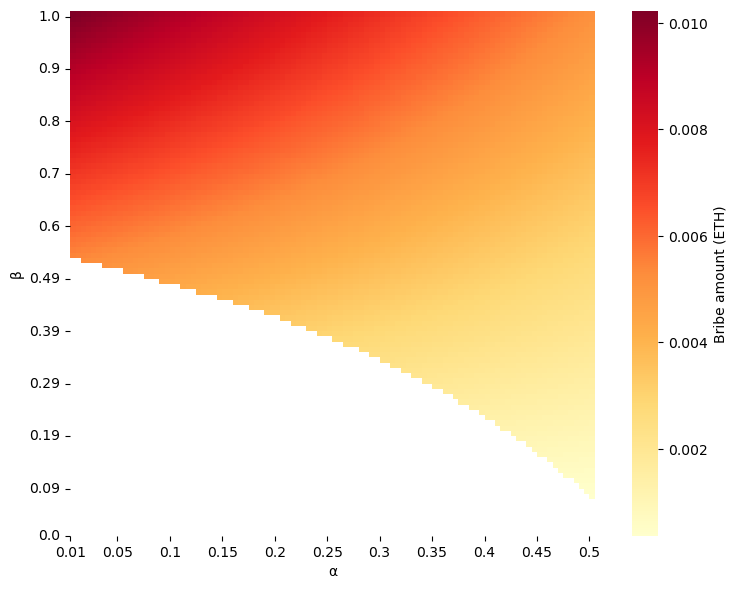

In [10]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)

# L = 2 # fork_lengths
# F0 = 2
# k = 0.1
# canonical_length = 2
# F = F0 * np.exp(-k * L)

bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):

        lhs = 2 * (1 - alpha) * (1 - beta)
        # lhs = F * (1 - beta) * (1 - alpha) * L + (1 - alpha) * canonical_length

        rhs = 0.4 + alpha + (1 - alpha) * beta
        # rhs = alpha * canonical_length + F * alpha * L + F * beta * (1 - alpha) * L

        if lhs < rhs:

            bribe[i, j] = (
                beta
                * (1 - alpha)
                * noOfValidators
                * attestation_reward_per_validator
                / 32
            )
            # bribe[i, j] = L * beta * (1 - alpha) * noOfValidators * attestation_reward_per_validator / 32

        # ábrázolni: (1-\alpha) \cdot \beta


vmin_bribe = np.nanmin(bribe)
vmax_bribe = np.nanmax(bribe)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (ETH)"},
    vmin=vmin_bribe,
    vmax=vmax_bribe,
)

ax.set_xlabel("α")
ax.set_ylabel("β")
ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center")
ax.invert_yaxis()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

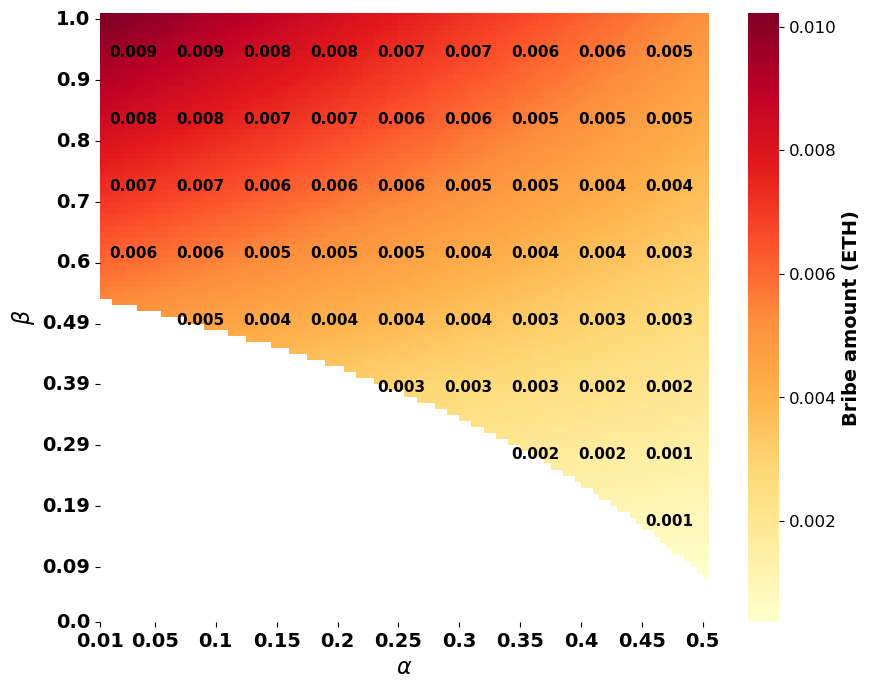

In [11]:
matplot2tikz.clean_figure()

plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (ETH)"},
    vmin=vmin_bribe,
    vmax=vmax_bribe,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\beta$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(beta_vals), 11):
    for j in range(5, len(alpha_vals), 11):
        value = bribe[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{value:.3f}",
                ha="center",
                va="center",
                fontsize=11,
                fontweight="bold",
                color="black",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Bribe amount (ETH)", fontsize=14, fontweight="bold")

plt.tight_layout()
matplot2tikz.save("PayToAttest_BribeAmount.tex")
plt.savefig("PayToAttest_BribeAmount.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Pay-To-Attest bribing timeline


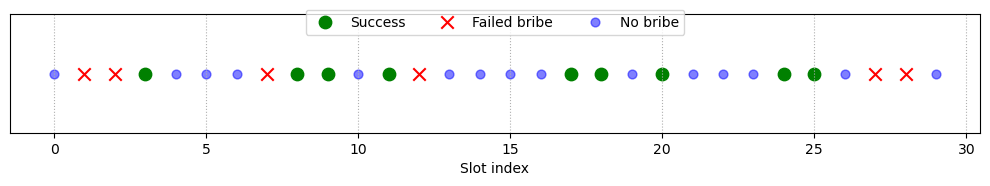

In [12]:
np.random.seed(42)
n_slots = 30

bribing_attempted = np.random.choice([0, 1], size=n_slots, p=[0.4, 0.6])
bribing_success = bribing_attempted * np.random.choice(
    [0, 1], size=n_slots, p=[0.3, 0.7]
)

slots = np.arange(n_slots)

plt.figure(figsize=(10, 2))
plt.scatter(
    slots[bribing_success == 1],
    [1] * sum(bribing_success == 1),
    color="green",
    label="Success",
    marker="o",
    s=80,
)
plt.scatter(
    slots[(bribing_attempted == 1) & (bribing_success == 0)],
    [1] * sum((bribing_attempted == 1) & (bribing_success == 0)),
    color="red",
    label="Failed bribe",
    marker="x",
    s=80,
)
plt.scatter(
    slots[bribing_attempted == 0],
    [1] * sum(bribing_attempted == 0),
    color="blue",
    label="No bribe",
    marker="o",
    s=40,
    alpha=0.5,
)

plt.yticks([])
plt.xlabel("Slot index")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.grid(axis="x", linestyle="dotted")
plt.tight_layout()
plt.show()

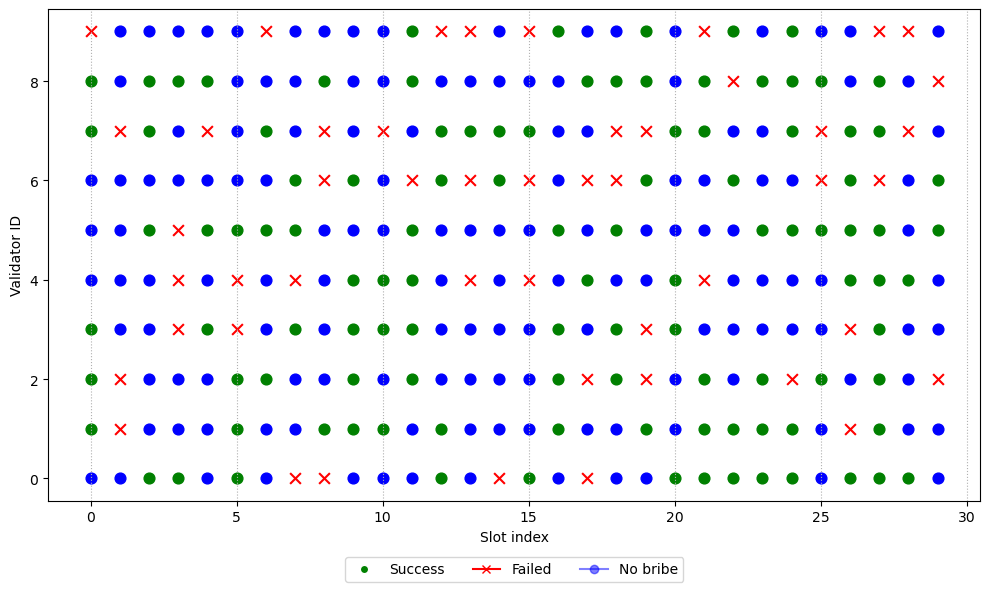

In [13]:
np.random.seed(42)
n_slots = 30
n_validators = 10

bribing_matrix = np.random.choice([0, 1], size=(n_slots, n_validators), p=[0.5, 0.5])
success_matrix = bribing_matrix * np.random.choice(
    [0, 1], size=(n_slots, n_validators), p=[0.3, 0.7]
)

fig, ax = plt.subplots(figsize=(10, 6))

for slot in range(n_slots):
    for val in range(n_validators):
        if bribing_matrix[slot, val] == 0:
            color, marker = "blue", "o"
        elif success_matrix[slot, val] == 1:
            color, marker = "green", "o"
        else:
            color, marker = "red", "x"
        ax.scatter(slot, val, color=color, marker=marker, s=60)

ax.set_xlabel("Slot index")
ax.set_ylabel("Validator ID")
ax.legend(
    handles=[
        plt.Line2D(
            [0], [0], marker="o", color="w", markerfacecolor="green", label="Success"
        ),
        plt.Line2D([0], [0], marker="x", color="red", label="Failed"),
        plt.Line2D([0], [0], marker="o", color="blue", label="No bribe", alpha=0.5),
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
)
plt.grid(True, axis="x", linestyle="dotted")
plt.tight_layout()
plt.show()

- zöld = elfogadta a bribet és attesztált
- piros = bribing történt, de visszautasította
- kék = nem történt bribing


In [14]:
df_different = pd.read_csv("diff_output.csv")
df_different.columns = df_different.columns.str.strip()

different_messages_data = list(
    zip(
        df_different["messages"],
        df_different["total_gas"],
        df_different["gas_per_message"],
    )
)

df_same = pd.read_csv("same_output.csv")
df_same.columns = df_same.columns.str.strip()

same_messages_data = list(
    zip(
        df_same["messages"],
        df_same["total_gas"],
        df_same["gas_per_message"],
    )
)

df_different = pd.DataFrame(
    different_messages_data, columns=["messages", "total_gas", "gas_per_message"]
)

df_same = pd.DataFrame(
    same_messages_data, columns=["messages", "total_gas", "gas_per_message"]
)

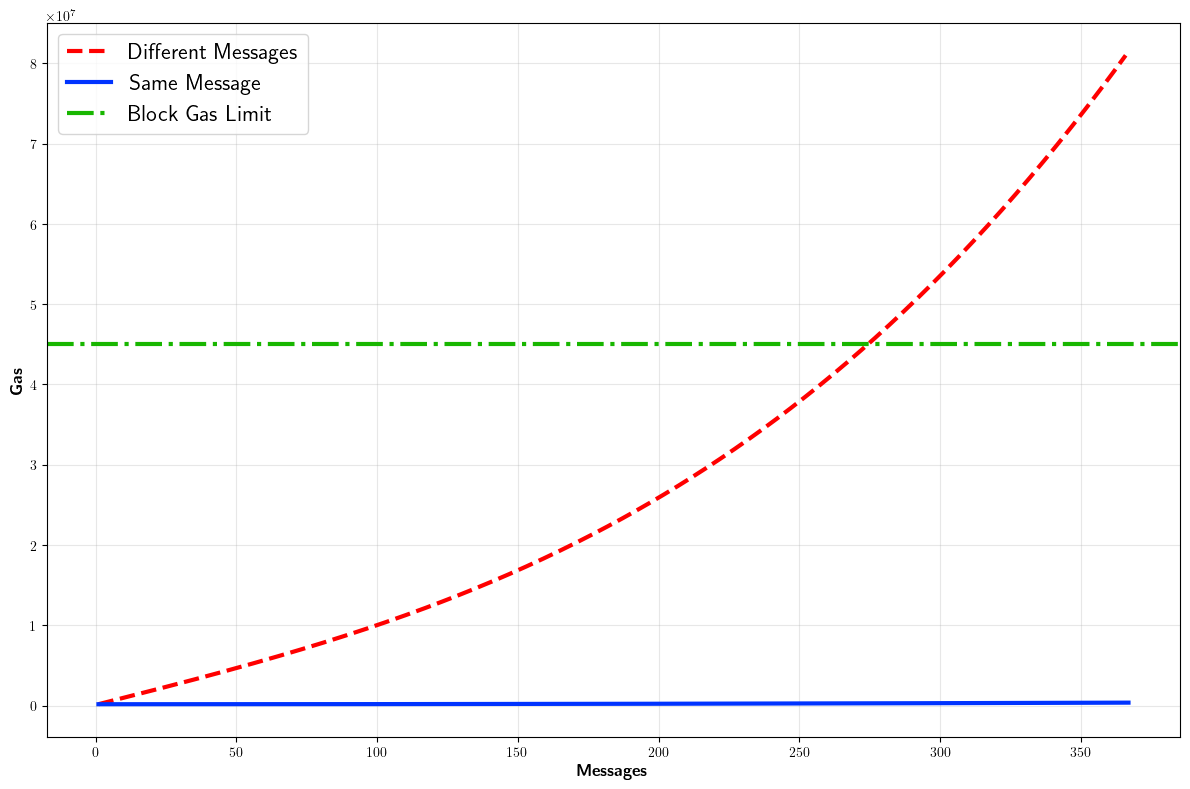

In [17]:
import matplotlib

plt.rcParams.update(
    {
        "text.usetex": True,
    }
)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

ax1.plot(
    df_different["messages"],
    df_different["total_gas"],
    "--",
    color="#FF0000",
    linewidth=3,
    markersize=6,
    label="Different Messages",
)
ax1.plot(
    df_same["messages"],
    df_same["total_gas"],
    "-",
    color="#0033FF",
    linewidth=3,
    markersize=6,
    label="Same Message",
)
ax1.axhline(
    45_000_000, color="#18B600", linestyle="-.", linewidth=3, label="Block Gas Limit"
)
ax1.set_xlabel(r"$\textbf{Messages}$", fontsize=12)
ax1.set_ylabel(r"$\textbf{Gas}$", fontsize=12)

ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=16)

plt.tight_layout()
plt.show()

<>:35: SyntaxWarning: invalid escape sequence '\%'
<>:35: SyntaxWarning: invalid escape sequence '\%'
/var/folders/bs/mcr4twx959ndzlf0j55vycz00000gn/T/ipykernel_75704/1646466737.py:35: SyntaxWarning: invalid escape sequence '\%'
  f"{percentage_savings[i]:.1f}\%",


([<matplotlib.axis.XTick at 0x17ae6b110>,
 [Text(0, 0, '$\\mathdefault{0}$'),
  Text(5, 0, '$\\mathdefault{5}$'),
  Text(10, 0, '$\\mathdefault{10}$'),
  Text(15, 0, '$\\mathdefault{15}$'),
  Text(20, 0, '$\\mathdefault{20}$'),
  Text(25, 0, '$\\mathdefault{25}$')])

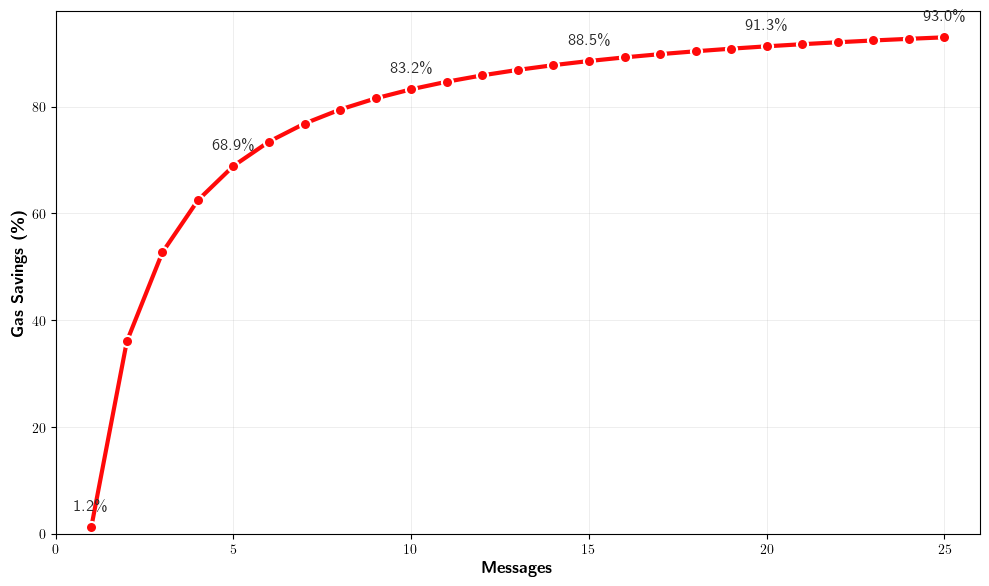

In [18]:
plt.figure(figsize=(10, 6))

overlap_messages = []
percentage_savings = []

for msg_count in range(1, 26):
    diff_row = df_different[df_different["messages"] == msg_count]
    same_row = df_same[df_same["messages"] == msg_count]

    if not diff_row.empty and not same_row.empty:
        diff_gas = diff_row.iloc[0]["gas_per_message"]
        same_gas = same_row.iloc[0]["gas_per_message"]

        savings = ((diff_gas - same_gas) / diff_gas) * 100

        overlap_messages.append(msg_count)
        percentage_savings.append(savings)

plt.plot(
    overlap_messages,
    percentage_savings,
    "o-",
    color="#FF0A0A",
    linewidth=3,
    markersize=8,
    markerfacecolor="#FF0A0A",
    markeredgecolor="white",
    markeredgewidth=1.5,
)

label_points = [1, 5, 10, 15, 20, 25]
for i, msg_count in enumerate(overlap_messages):
    if msg_count in label_points:
        plt.annotate(
            f"{percentage_savings[i]:.1f}\%",
            (msg_count, percentage_savings[i]),
            textcoords="offset points",
            xytext=(0, 12),
            ha="center",
            fontsize=12,
            fontweight="bold",
            color="#2E2E2E",
        )

plt.xlabel(r"$\textbf{Messages}$", fontsize=12)
plt.ylabel(r"$\textbf{Gas Savings (\%)}$", fontsize=12)
plt.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)
plt.xlim(0, 26)
plt.ylim(0, max(percentage_savings) + 5)
plt.tight_layout()
plt.xticks(range(0, 26, 5))

In [ ]:
df = pd.read_csv("pay_to_bias_measurements.csv")

plt.rcParams.update(
    {
        "text.usetex": True,
    }
)

fig = plt.figure(figsize=(1, 1))
ax = fig.add_axes([0, 0, 5, 5])
ax.plot(range(2, 32), df["take"], label="takeBribe()")
ax.plot(range(2, 32), df["offer"], label="offerBribe()")
ax.set_ylabel(r"\textbf{s}", fontsize=14)
ax.set_xlabel(r"", fontsize=14)
plt.legend()
plt.show()

# Pay To Exit


In [20]:
def getMaxIssuancePerYear(noOfValidators):
    return 940.8659 * math.sqrt(noOfValidators)


def getAPR(noOfValidators):
    return 2940.21 / math.sqrt(noOfValidators)

<Figure size 640x480 with 0 Axes>

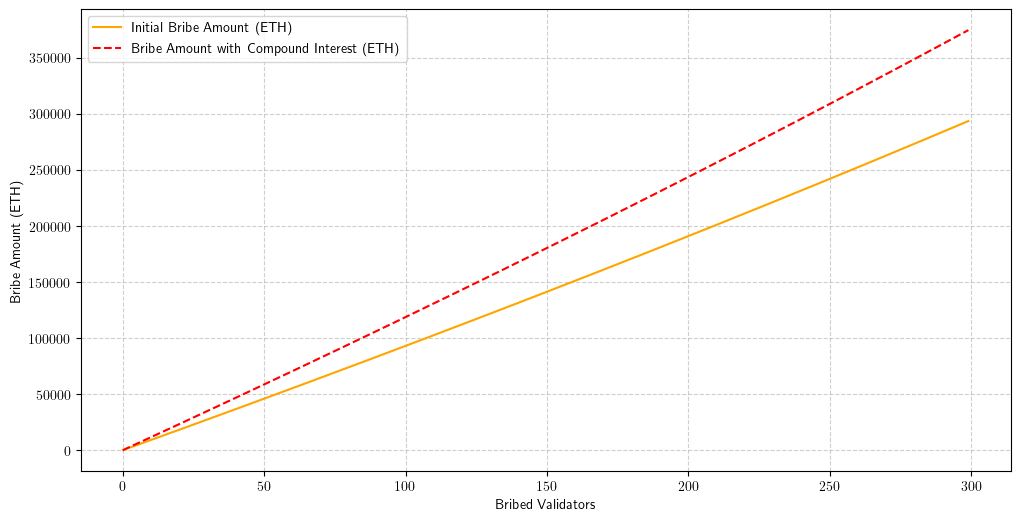

In [23]:
noOfBribedValidators = 300000

matplot2tikz.clean_figure()

oneYearRewards = [
    32 * getAPR(i) / 100
    for i in range(noOfValidators, noOfValidators - noOfBribedValidators, -1)
]
bribeAmounts = np.cumsum(oneYearRewards)

step = 1000  # take every 1000th data point
bribeAmounts = bribeAmounts[::step]

interest_rate = 0.05  # 5% annual interest rate
years = 5

bribeWithInterest = bribeAmounts * (1 + interest_rate) ** years

plt.figure(figsize=(12, 6))
plt.plot(bribeAmounts, label="Initial Bribe Amount (ETH)", color="orange")
plt.plot(
    bribeWithInterest,
    label="Bribe Amount with Compound Interest (ETH)",
    linestyle="--",
    color="red",
)
plt.xlabel("Bribed Validators")
plt.ylabel("Bribe Amount (ETH)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
# plt.savefig("bls_gas_costs.pdf", format="pdf", bbox_inches="tight")
matplot2tikz.save("bls_gas_costs.tex")
plt.show()

In [ ]:
def compute_bribe_cost(alpha, alpha_star):
    if alpha_star < alpha:
        return np.nan

    current_validators = int(alpha * noOfValidators)
    target_validators = int(alpha_star * noOfValidators)
    bribed = target_validators - current_validators

    if bribed <= 0:
        return np.nan

    one_year_rewards = [
        32 * getAPR(i) / 100
        for i in range(current_validators, current_validators + bribed)
    ]
    bribe_amounts = np.cumsum(one_year_rewards)
    bribe_with_interest = bribe_amounts * (1 + interest_rate) ** years

    return bribe_with_interest[-1]


alpha_vals = np.linspace(0.01, 0.5, 100)
alpha_star_vals = np.linspace(0.01, 0.5, 100)


bribe_cost = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        bribe_cost[i, j] = compute_bribe_cost(alpha, alpha_star)


vmin = np.nanmin(bribe_cost)
vmax = np.nanmax(bribe_cost)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)

<Figure size 640x480 with 0 Axes>

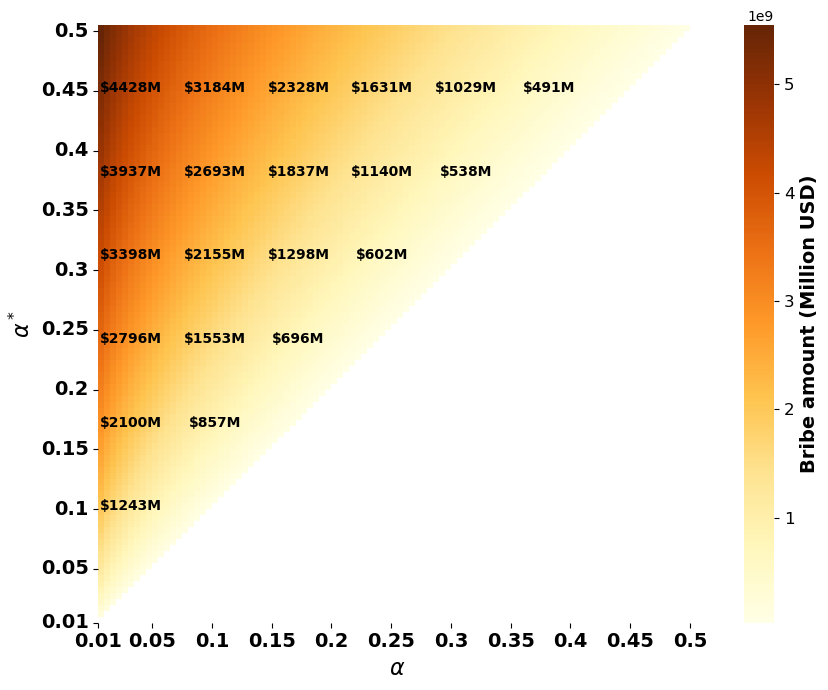

In [ ]:
eth_usd_rate = 3668.77  # USD / ETH (2025-04-01 árfolyam)

bribe_cost_usd = bribe_cost * eth_usd_rate

vmin = np.nanmin(bribe_cost_usd)
vmax = np.nanmax(bribe_cost_usd)

matplot2tikz.clean_figure()

plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    bribe_cost_usd,
    cmap="YlOrBr",
    mask=np.isnan(bribe_cost_usd),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Bribe amount (Million USD)"},
    vmin=vmin,
    vmax=vmax,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 14):
    for j in range(5, len(alpha_vals), 14):
        value = bribe_cost_usd[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"${value/1e6:.0f}M",
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
                color="black",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Bribe amount (Million USD)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("PayToExit_BribeHeatmap.pdf", format="pdf", bbox_inches="tight")
matplot2tikz.save("PayToExit_BribeHeatmap.tex")
plt.show()

### Pay to exit: attack duration


<Figure size 640x480 with 0 Axes>

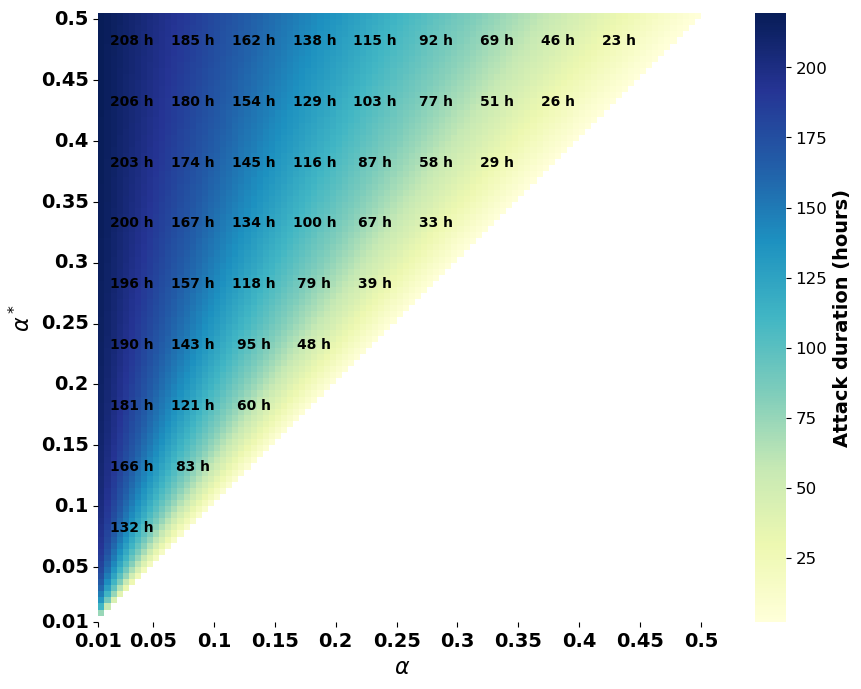

In [ ]:
validators_per_block = 16
block_time_sec = 12

alpha_vals = np.linspace(0.01, 0.5, 100)
alpha_star_vals = np.linspace(0.01, 0.5, 100)

attack_time = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        if alpha_star > alpha:
            delta_validators = noOfValidators * (alpha_star - alpha) / alpha_star

            delta_validators = math.ceil(delta_validators)

            blocks_needed = delta_validators / validators_per_block
            time_hours = (blocks_needed * block_time_sec) / 3600.0
            attack_time[i, j] = time_hours

vmin = np.nanmin(attack_time)
vmax = np.nanmax(attack_time)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)
yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)

matplot2tikz.clean_figure()

plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    attack_time,
    cmap="YlGnBu",
    mask=np.isnan(attack_time),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Attack duration (hours)"},
    vmin=vmin,
    vmax=vmax,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 10):
    for j in range(5, len(alpha_vals), 10):
        value = attack_time[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{value:.0f} h",
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
                color="black",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Attack duration (hours)", fontsize=14, fontweight="bold")

plt.tight_layout()
matplot2tikz.save("PayToExit_AttackDuration.tex")
plt.savefig("PayToExit_AttackDuration.pdf", format="pdf", bbox_inches="tight")
plt.show()

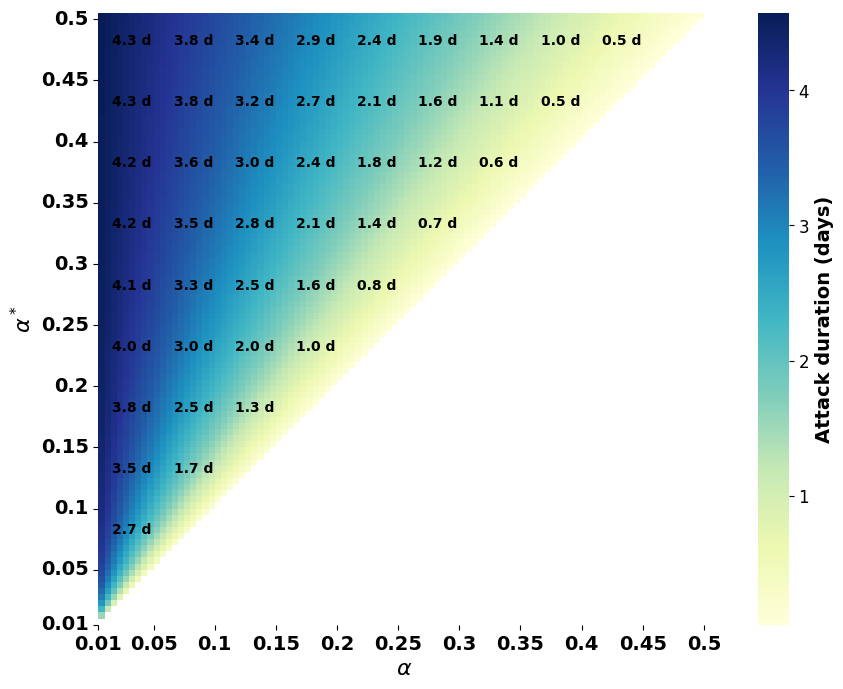

In [ ]:
attack_time_days = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        if alpha_star > alpha:
            delta_validators = math.ceil(
                noOfValidators * (alpha_star - alpha) / alpha_star
            )

            blocks_needed = delta_validators / validators_per_block
            time_days = (blocks_needed * block_time_sec) / 86400.0
            attack_time_days[i, j] = time_days

vmin = np.nanmin(attack_time_days)
vmax = np.nanmax(attack_time_days)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)
yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    attack_time_days,
    cmap="YlGnBu",
    mask=np.isnan(attack_time_days),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Attack duration (days)"},
    vmin=vmin,
    vmax=vmax,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 10):
    for j in range(5, len(alpha_vals), 10):
        value = attack_time_days[i, j]
        if not np.isnan(value):
            txt = f"{value:.1f} d" if value < 100 else f"{value:.0f} d"
            ax.text(
                j + 0.5,
                i + 0.5,
                txt,
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
                color="black",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Attack duration (days)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("PayToExit_AttackDuration_days.pdf", format="pdf", bbox_inches="tight")
plt.show()

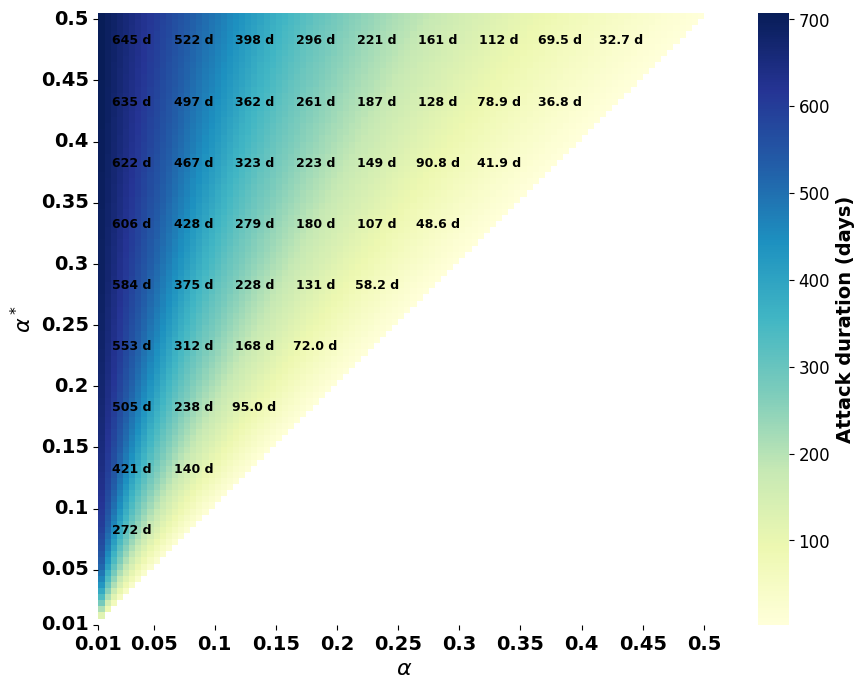

In [ ]:
# masik modszer, nem biztos hogy jo
slot_time_sec = 12
slots_per_epoch = 32
epoch_time_sec = slot_time_sec * slots_per_epoch  # 384 s


def churn_limit_per_epoch(N: int) -> int:
    MIN_PER_EPOCH_CHURN_LIMIT = 4
    CHURN_LIMIT_QUOTIENT = 65536
    return max(MIN_PER_EPOCH_CHURN_LIMIT, N // CHURN_LIMIT_QUOTIENT)


def required_exits(N: int, alpha: float, alpha_star: float) -> int:
    if alpha_star <= alpha:
        return 0
    return int(math.ceil(N * (alpha_star - alpha) / alpha_star))


def time_to_reach_days(N_start: int, alpha: float, alpha_star: float) -> float:
    if alpha_star <= alpha:
        return np.nan

    remaining = required_exits(N_start, alpha, alpha_star)
    if remaining <= 0:
        return np.nan

    N = N_start
    epochs = 0
    while remaining > 0:
        c = churn_limit_per_epoch(N)
        exits = min(c, remaining)
        remaining -= exits
        N -= exits
        epochs += 1

    days = (epochs * epoch_time_sec) / 86400.0  # 86400 s = 1 nap
    return days


attack_time_days = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        if alpha_star > alpha:
            attack_time_days[i, j] = time_to_reach_days(
                noOfValidators, alpha, alpha_star
            )

vmin = np.nanmin(attack_time_days)
vmax = np.nanmax(attack_time_days)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)
yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    attack_time_days,
    cmap="YlGnBu",
    mask=np.isnan(attack_time_days),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Attack duration (days)"},
    vmin=vmin,
    vmax=vmax,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 10):
    for j in range(5, len(alpha_vals), 10):
        val = attack_time_days[i, j]
        if not np.isnan(val):
            txt = f"{val:.1f} d" if val < 100 else f"{val:.0f} d"
            ax.text(
                j + 0.5,
                i + 0.5,
                txt,
                ha="center",
                va="center",
                fontsize=9,
                fontweight="bold",
                color="black",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Attack duration (days)", fontsize=14, fontweight="bold")

plt.tight_layout()
# plt.savefig("pay_to_exit_attack_duration_days_churn.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Pay-To-Exit gas cost vs number of blocks


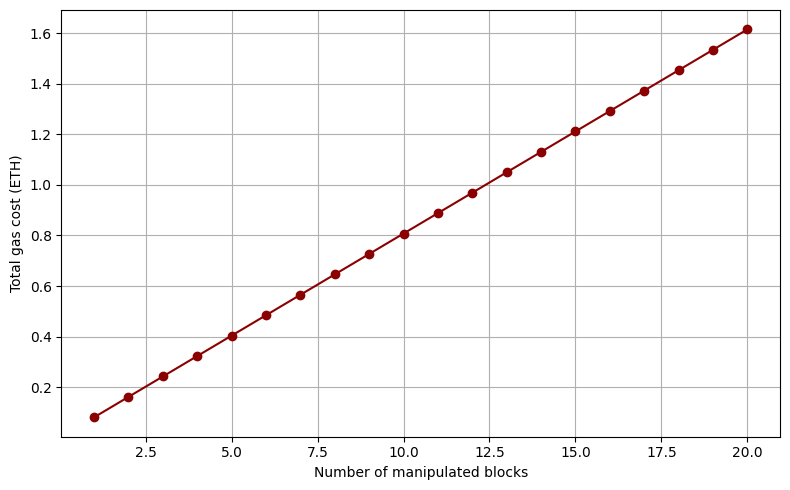

In [ ]:
validators_per_block = 32
offer_gas = 60000
take_gas = 1150660
total_gas_per_validator = offer_gas + take_gas

gwei_price = 2.084 / 1e9
eth_usd_price = 3668.77

blocks = list(range(1, 21))
eth_costs = []
usd_costs = []

for b in blocks:
    total_validators = b * validators_per_block
    total_gas = total_validators * total_gas_per_validator
    eth_cost = total_gas * gwei_price
    usd_cost = eth_cost * eth_usd_price
    eth_costs.append(eth_cost)
    usd_costs.append(usd_cost)

plt.figure(figsize=(8, 5))
plt.plot(blocks, eth_costs, marker="o", color="darkred")
plt.xlabel("Number of manipulated blocks")
plt.ylabel("Total gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

- the total gas cost increases with the number of blocks a briber attempts to manipulate in order to force a validator to exit the system
- each block requires bribing 32 validators using both offerBribe() and takeBribe() functions
- making the cost grow linearly with the number of targeted blocks


### Pay-To-Exit cost and block duration


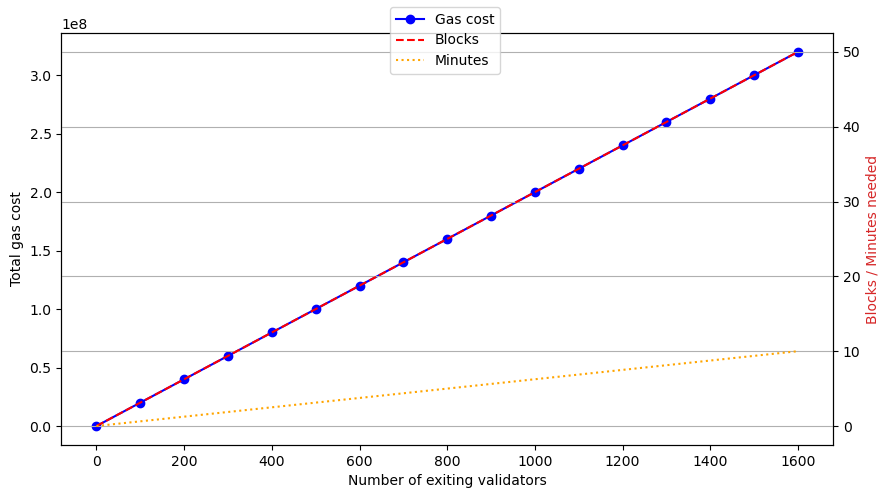

In [ ]:
validators_to_exit = list(range(0, 1601, 100))
gas_per_validator = 200_000
validators_per_block = 32
block_time_seconds = 12

total_gas = [v * gas_per_validator for v in validators_to_exit]
blocks_needed = [v / validators_per_block for v in validators_to_exit]
time_minutes = [b * block_time_seconds / 60 for b in blocks_needed]

fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.set_xlabel("Number of exiting validators")
ax1.set_ylabel("Total gas cost")
ax1.plot(validators_to_exit, total_gas, color=color, marker="o", label="Gas cost")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Blocks / Minutes needed", color=color)
ax2.plot(validators_to_exit, blocks_needed, color="red", linestyle="--", label="Blocks")
ax2.plot(
    validators_to_exit, time_minutes, color="orange", linestyle=":", label="Minutes"
)
ax2.tick_params(axis="y")

fig.tight_layout()
fig.legend(loc="upper center")
plt.grid(True)
plt.show()

# Pay to bias


### gas cost vs number of tail slots


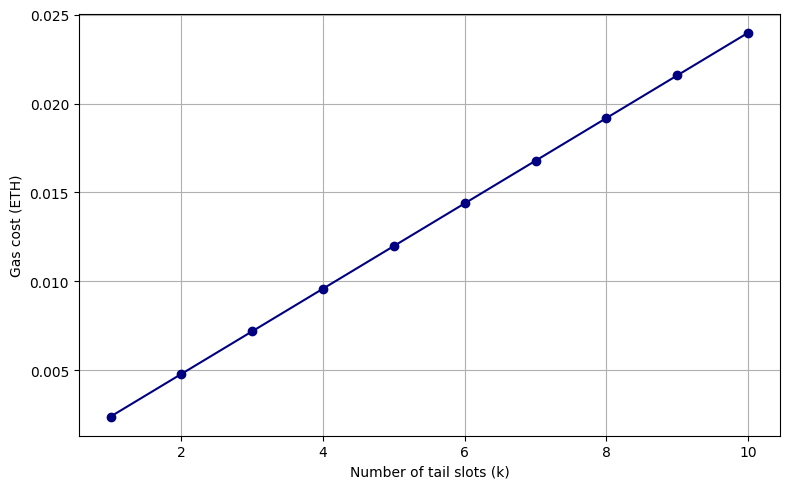

In [ ]:
tail_slots = list(range(1, 11))

base_gas_per_verification = 1150660  # from Table2

gas_costs = [k * base_gas_per_verification for k in tail_slots]

eth_usd_price = 3668.77
gwei_price = 2.084 / 1e9  # ETH
usd_costs = [gas * gwei_price * eth_usd_price for gas in gas_costs]
eth_costs = [gas * gwei_price for gas in gas_costs]


plt.figure(figsize=(8, 5))
plt.plot(tail_slots, eth_costs, marker="o", color="navy")
plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

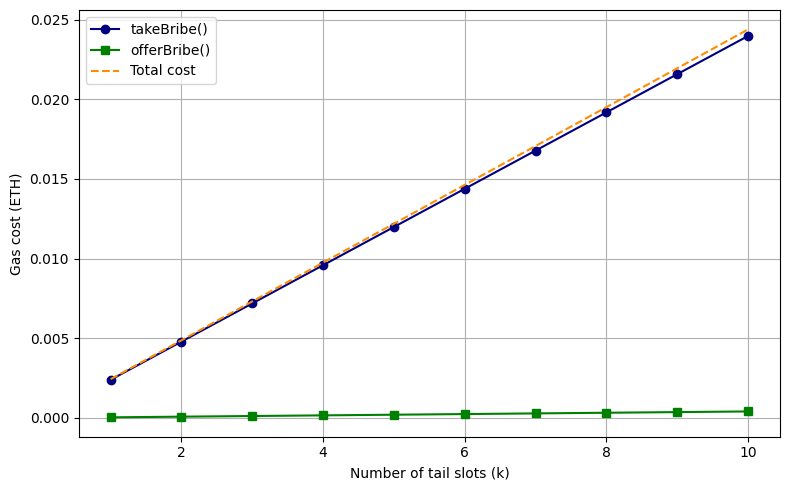

In [ ]:
tail_slots = list(range(1, 11))

gas_take_bribe = 1150660
gas_offer_bribe = 19678

gwei_price_eth = 2.084 / 1e9
eth_usd_price = 3668.77

eth_cost_take = [k * gas_take_bribe * gwei_price_eth for k in tail_slots]
eth_cost_offer = [k * gas_offer_bribe * gwei_price_eth for k in tail_slots]
eth_cost_total = [take + offer for take, offer in zip(eth_cost_take, eth_cost_offer)]

plt.figure(figsize=(8, 5))
plt.plot(tail_slots, eth_cost_take, label="takeBribe()", marker="o", color="navy")
plt.plot(tail_slots, eth_cost_offer, label="offerBribe()", marker="s", color="green")
plt.plot(
    tail_slots, eth_cost_total, label="Total cost", linestyle="--", color="darkorange"
)

plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Histogram


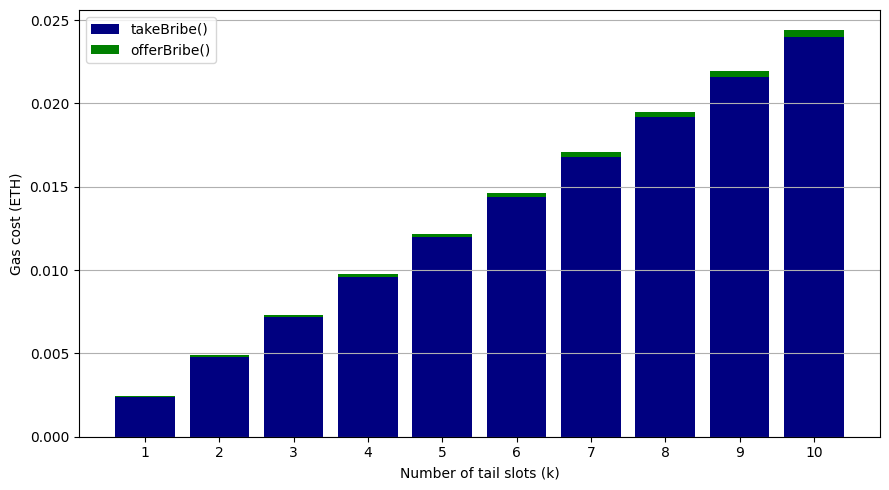

In [ ]:
tail_slots = list(range(1, 11))

gas_take_bribe = 1150660
gas_offer_bribe = 19678

gwei_price_eth = 2.084 / 1e9

eth_cost_take = [k * gas_take_bribe * gwei_price_eth for k in tail_slots]
eth_cost_offer = [k * gas_offer_bribe * gwei_price_eth for k in tail_slots]

x = np.arange(len(tail_slots))

plt.figure(figsize=(9, 5))
plt.bar(x, eth_cost_take, label="takeBribe()", color="navy")
plt.bar(x, eth_cost_offer, bottom=eth_cost_take, label="offerBribe()", color="green")

plt.xticks(x, tail_slots)
plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

- shows how the total gas cost increases as the attacker attempts to influence more tail slots
- for each slot the attacker must call both offerBribe() and takeBribe()
- which together make the cost grow linearly with the number of slots


#### Gas Cost vs. Published Slot Ratio


In [ ]:
k = 10  # tail slot
gas_per_slot = 93156
gas_price_gwei = 3.66877
gwei_to_eth = 1e-9

ratios = np.linspace(0, 1, 11)

published_slots = ratios * k

total_gas = published_slots * gas_per_slot
total_eth_cost = total_gas * gas_price_gwei * gwei_to_eth

plt.figure(figsize=(8, 6))
plt.plot(ratios, total_eth_cost, marker="o", color="darkgreen")
plt.xlabel("Published tail slots ratio")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Bribery timeline in Pay-to-Bias


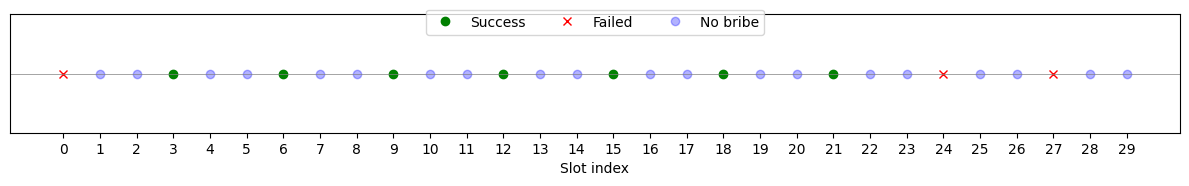

In [ ]:
# np.random.seed(42)

num_slots = 30
bias_threshold = 0.6
slots = np.arange(num_slots)

bribe_offered = np.zeros(num_slots, dtype=bool)
bribe_offered[::3] = True

bribe_successful = np.zeros(num_slots, dtype=bool)
bribe_successful[bribe_offered] = np.random.rand(np.sum(bribe_offered)) > 0.3

plt.figure(figsize=(12, 2))
plt.plot([], [], "go", label="Success")
plt.plot([], [], "rx", label="Failed")
plt.plot([], [], "bo", alpha=0.3, label="No bribe")

for i in range(num_slots):
    if bribe_offered[i]:
        if bribe_successful[i]:
            plt.plot(i, 0, "go")
        else:
            plt.plot(i, 0, "rx")
    else:
        plt.plot(i, 0, "bo", alpha=0.3)

plt.axhline(0, color="gray", linewidth=0.5)
plt.xticks(slots)
plt.yticks([])
plt.xlabel("Slot index")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.tight_layout()
plt.show()

- the outcome of bribing attempts across 30 consecutive slots, each point represents a slot
- Green dots: successful bribing, where the attacker’s manipulated block was published
- Red X marks: failed bribing attempts, where a bribe was offered but did not result in a successful publication
- Blue circles represent no bribing attempt in that slot.


# Countermeasures


In [ ]:
date_range = pd.date_range(start="2020-01-01", end="2025-01-01", freq="D")
num_days = len(date_range)

eth_supply = 110 + 0.005 * (
    pd.Series(range(num_days)) + (np.random.randn(num_days) * 0.2).cumsum()
)
eth_supply = eth_supply.round(3)

price = (
    2000
    + (np.sin(np.linspace(0, 20, num_days)) * 200)
    + (np.random.randn(num_days) * 100).cumsum()
)
price = pd.Series(price).clip(lower=100)

df = pd.DataFrame(
    {"date": date_range, "eth_supply_millions": eth_supply, "eth_usd_price": price}
)
df["eth_supply"] = df["eth_supply_millions"] * 1e6
df["eth_inflation"] = df["eth_supply"].pct_change()
df["price_return"] = df["eth_usd_price"].pct_change()
df.dropna(inplace=True)
df["eth_inflation_percent"] = df["eth_inflation"] * 100
print(df.tail())

           date  eth_supply_millions  eth_usd_price   eth_supply  \
1823 2024-12-28              119.119    5283.021932  119119000.0   
1824 2024-12-29              119.125    5046.328113  119125000.0   
1825 2024-12-30              119.130    4996.545214  119130000.0   
1826 2024-12-31              119.136    5090.713156  119136000.0   
1827 2025-01-01              119.138    5013.613268  119138000.0   

      eth_inflation  price_return  eth_inflation_percent  
1823       0.000034     -0.012732               0.003358  
1824       0.000050     -0.044803               0.005037  
1825       0.000042     -0.009865               0.004197  
1826       0.000050      0.018847               0.005037  
1827       0.000017     -0.015145               0.001679  


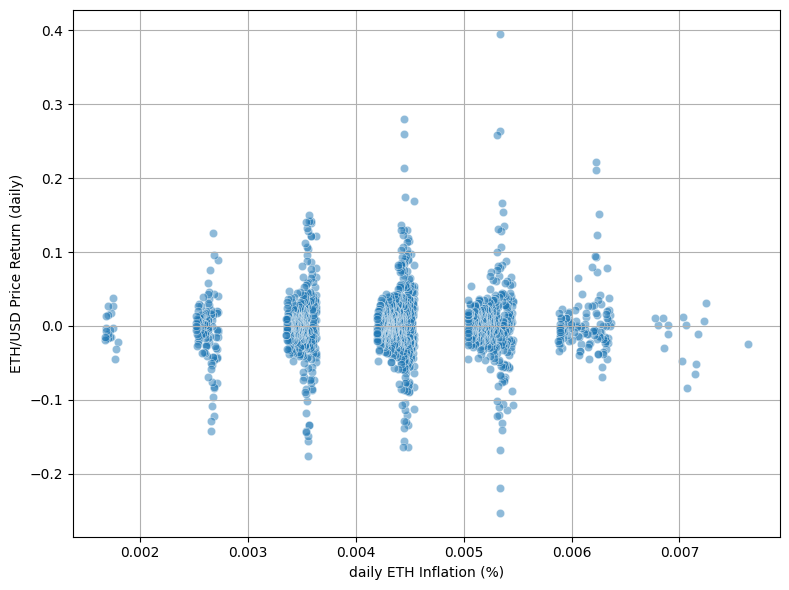

Korreláció: 0.0247
                            OLS Regression Results                            
Dep. Variable:           price_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.114
Date:                Thu, 14 Aug 2025   Prob (F-statistic):              0.291
Time:                        19:37:40   Log-Likelihood:                 3160.6
No. Observations:                1827   AIC:                            -6317.
Df Residuals:                    1825   BIC:                            -6306.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0035   

In [ ]:
import statsmodels.api as sm

plt.figure(figsize=(8, 6))
sns.scatterplot(x="eth_inflation_percent", y="price_return", data=df, alpha=0.5)
plt.xlabel("daily ETH Inflation (%)")
plt.ylabel("ETH/USD Price Return (daily)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
correlation = df["eth_inflation"].corr(df["price_return"])
print(f"Korreláció: {correlation:.4f}")

# Linear regression
X = sm.add_constant(df["eth_inflation"])
y = df["price_return"]
model = sm.OLS(y, X).fit()
print(model.summary())

### ETH/USD Price vs Issuance Rate


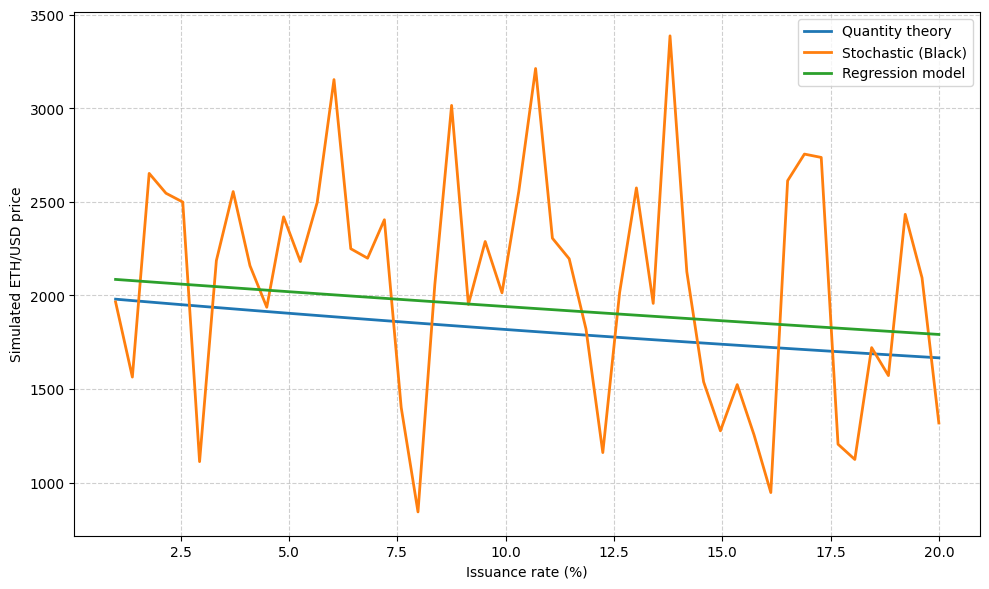

In [ ]:
initial_price = 2000
issuance_rates = np.linspace(0.01, 0.2, 50)


# 1. Quantity theory of money (MV = PY) model
def quantity_theory_model(M0=100, V=5, Y=500):
    prices = []
    for i_rate in issuance_rates:
        M = M0 * (1 + i_rate)
        P = (M * V) / Y
        eth_price = initial_price * (1 / P)  # ETH/USD
        prices.append(eth_price)
    return prices


# 2. Stochastic modell (Black)
def stochastic_black_model(mu=0.08, sigma=0.3, T=1, dt=1 / 252):
    time_grid = np.arange(0, T, dt)
    final_prices = []
    for pi in issuance_rates:
        price = initial_price
        for _ in time_grid:
            dW = np.random.normal(0, np.sqrt(dt))
            price *= np.exp((mu - pi - 0.5 * sigma**2) * dt + sigma * dW)
        final_prices.append(price)
    return final_prices


# 3.Regression model
def regression_model(beta_0=0.05, beta_1=-0.8, T=1):
    log_returns = beta_0 + beta_1 * issuance_rates
    prices = initial_price * np.exp(log_returns * T)
    return prices


qt_prices = quantity_theory_model()
stoch_prices = stochastic_black_model()
reg_prices = regression_model()

df = pd.DataFrame(
    {
        "Issuance Rate (%)": issuance_rates * 100,
        "QuantityTheory": qt_prices,
        "StochasticModel": stoch_prices,
        "RegressionModel": reg_prices,
    }
)
# print(df.round(2))

plt.figure(figsize=(10, 6))
plt.plot(issuance_rates * 100, qt_prices, label="Quantity theory", linewidth=2)
plt.plot(issuance_rates * 100, stoch_prices, label="Stochastic (Black)", linewidth=2)
plt.plot(issuance_rates * 100, reg_prices, label="Regression model", linewidth=2)
plt.xlabel("Issuance rate (%)")
plt.ylabel("Simulated ETH/USD price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### ETH/USD price - time graph


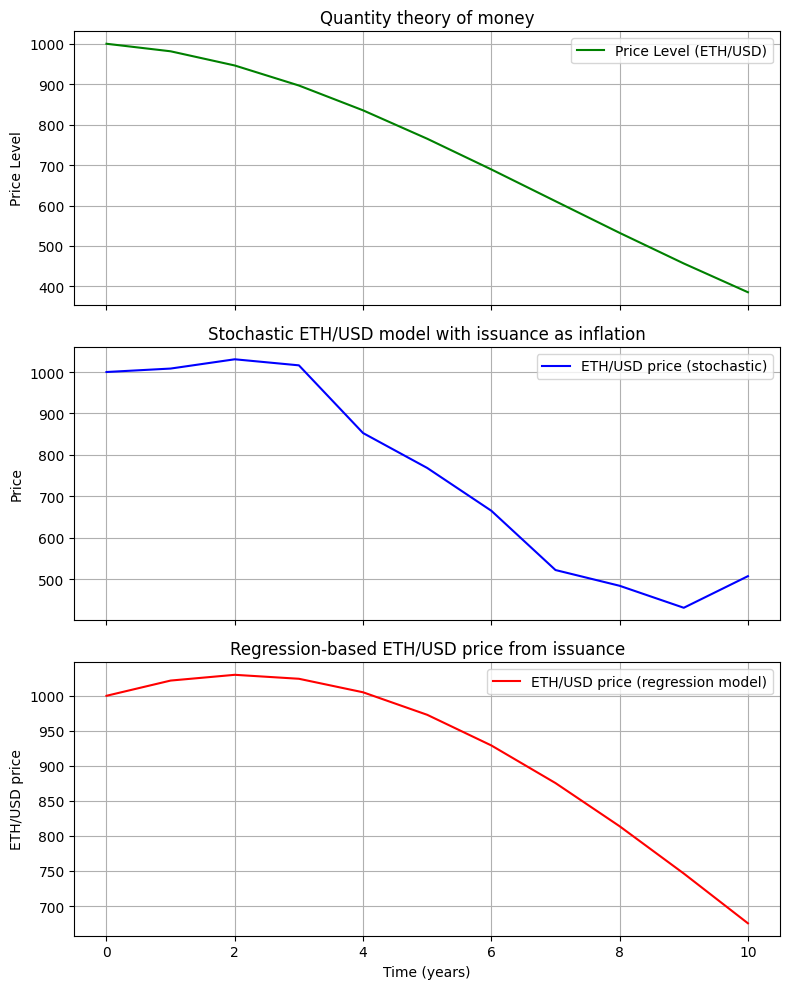

In [ ]:
initial_price = 1000
years = 10
time = np.arange(0, years + 1)

issuance_rate = np.linspace(0.01, 0.10, len(time))


def quantity_theory(M0=100, V=1, Y=100):
    prices = []
    for i, pi in enumerate(issuance_rate):
        M = M0 * (1 + pi) ** i
        P = (M * V) / Y
        price = initial_price * (1 / P)
        prices.append(price)
    return prices


def stochastic_model(mu=0.05, sigma=0.2):
    dt = 1
    price = initial_price
    prices = [price]
    for i in range(1, len(time)):
        pi = issuance_rate[i]
        dW = np.random.normal(0, np.sqrt(dt))
        price *= np.exp((mu - pi - 0.5 * sigma**2) * dt + sigma * dW)
        prices.append(price)
    return prices


def regression_model(beta_0=0.05, beta_1=-1.5):
    log_returns = beta_0 + beta_1 * issuance_rate
    prices = [initial_price]
    for i in range(1, len(time)):
        new_price = prices[-1] * np.exp(log_returns[i])
        prices.append(new_price)
    return prices


qt_prices = quantity_theory()
stoch_prices = stochastic_model()
reg_prices = regression_model()

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(time, qt_prices, color="green", label="Price Level (ETH/USD)")
axs[0].set_title("Quantity theory of money")
axs[0].set_ylabel("Price Level")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(time, stoch_prices, color="blue", label="ETH/USD price (stochastic)")
axs[1].set_title("Stochastic ETH/USD model with issuance as inflation")
axs[1].set_ylabel("Price")
axs[1].grid(True)
axs[1].legend()

axs[2].plot(time, reg_prices, color="red", label="ETH/USD price (regression model)")
axs[2].set_title("Regression-based ETH/USD price from issuance")
axs[2].set_xlabel("Time (years)")
axs[2].set_ylabel("ETH/USD price")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

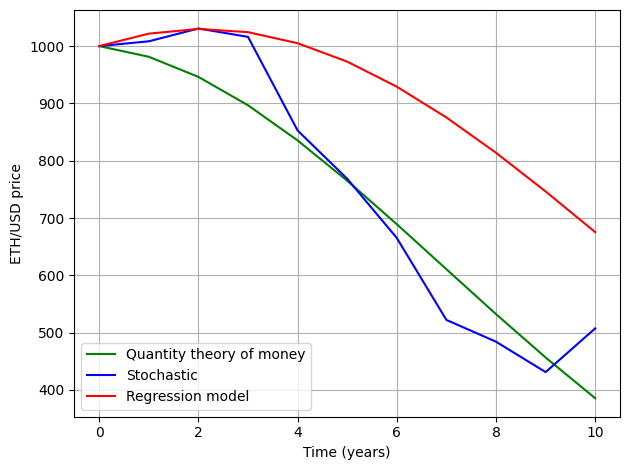

In [ ]:
plt.plot(time, qt_prices, color="green", label="Quantity theory of money")
plt.plot(time, stoch_prices, color="blue", label="Stochastic")
plt.plot(time, reg_prices, color="red", label="Regression model")
plt.xlabel("Time (years)")
plt.ylabel("ETH/USD price")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()